In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

In [2]:
import torch

import torchvision
import torchvision.transforms as transforms
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import statsmodels.formula.api as smf

In [3]:
# custom defined functions:
# now fit the powerlaw:

def func_powerlaw(x: float, a: float, c: float) -> float:
    return a + x**(-1 / 5) * c

#def func_powerlaw_exponent(x0: float, x1:float, x2:float, x3:float, x4:float, x5:float, x6:float, x7:float, x8:float, x9:float, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float) -> float:
#    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d10*epochs_trained)**b) * c

def func_powerlaw_exponent_epoch(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    #: float, x1:float, x2:float, x3:float, x4:float, x5:float, x6:float, x7:float, x8:float, x9:float
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c


def func_powerlaw_exponent_epoch_2(x, a: float, b: float, c: float, d_int:float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    #: float, x1:float, x2:float, x3:float, x4:float, x5:float, x6:float, x7:float, x8:float, x9:float
    return a + ((d_int + d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c

def func_powerlaw_exponent(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    #: float, x1:float, x2:float, x3:float, x4:float, x5:float, x6:float, x7:float, x8:float, x9:float
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9)**b) * c

### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [4]:
#results = pd.read_csv("Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_20230628.csv")
results = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
print(results.shape)
results.head(2)

(10800, 13)


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.1006,0.868126,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,0
1,0.1314,4.390345,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,5


In [5]:
# Filter data to start with 10 epochs:
# anything below a certain number of epochs seems to be very flaky.
mask = results.epochs_trained >= 10
results = results[mask].reset_index(drop=True)
mask = results_val.epochs_trained >= 10
results_val = results_val[mask].reset_index(drop=True)

results.head(4)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.1787,4.370253,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,10
1,0.2051,4.355270,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,15
2,0.2030,4.387133,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,20
3,0.2506,4.299767,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,25


In [6]:
### normalize results:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X = results.iloc[:, 1:])
results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
results_scaled.columns = results.iloc[:, 1:].columns
results = pd.concat([results["accs"], results_scaled], axis=1)
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.1787,0.004281,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000
1,0.2051,0.003710,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.027027


In [7]:
# using the same scaler for train and val:
results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
results_scaled_val.columns = results_val.iloc[:, 1:].columns
results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
results_val.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.2633,0.005252,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.000000
1,0.2866,0.009001,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.027027


In [8]:
xdata = np.transpose(results.to_numpy()[:, 2:])
y = results.to_numpy()[:, 0]
xdata_val = np.transpose(results_val.to_numpy()[:, 2:])
y_val = results_val.to_numpy()[:, 0]
xdata.shape
# try out, if the function works
#func_powerlaw_exponent_epoch(xdata, 0, 0.1, .3, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1)

(11, 10260)

# powerlaw - full option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [12]:
print(xdata.shape)
results.iloc[:, 2:].head(2)


(11, 10260)


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000
1,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.027027


In [95]:
def func_powerlaw_exponent_epoch(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    #: float, x1:float, x2:float, x3:float, x4:float, x5:float, x6:float, x7:float, x8:float, x9:float
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c



params, params_cov = curve_fit(func_powerlaw_exponent_epoch, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
print(params)
y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13])
#results["accs_hat"] = y_hat
print(((y_hat - y)**2).sum())


/tmp/ipykernel_364429/2581796869.py:14: RuntimeWarning: invalid value encountered in power
  return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c


[-0.05191464  0.40446368  0.37700809  0.95319015  0.79498191  0.75846883
  0.43407371  0.77031675  0.6992817   0.75561634  0.95828271  0.58193432
  0.63893863  1.5286968 ]
25.826384078945967


In [102]:
#p0 = [0.1, 0.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, 0.1]
#p0_2 = [0.1, 0.1, 0.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1]

p0 = np.random.uniform(low=0, high=1, size = 14)

try:
    params, params_cov = curve_fit(func_powerlaw_exponent_epoch, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    print(params)
    y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13])
    #results["accs_hat"] = y_hat
    print(((y_hat - y)**2).sum())
except:
    print("did not converge")



[-0.0519121   0.40446558  0.47107841  0.54951823  0.45831724  0.43726404
  0.2502508   0.44409642  0.40313996  0.43562081  0.55245609  0.33549316
  0.36835485  0.88131012]
25.82638408299153


In [21]:
# calculate least square value:

#y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[8], params[9], params[10], params[11], params[12])
#results["accs_hat"] = y_hat
#((y_hat - y)**2).sum()


40.07335610309743

The following dict with parameters can be interpreted: 
* The large an estimated parameter value for a level is, the higher the impact to the accuracy. 
* That means, it makes more sense to add images from the classes with the highest parameters.

In [103]:
levels = list(results.columns)[2:-1]
len(params)

params_dict = {"a": params[0], "b": params[1], "c": params[2]}#, levels[0]:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) 
for i in range(len(levels)):
    params_dict[levels[i]] = params[i + 3]
params_dict["epochs"] = params[-1]
params_dict

{'a': -0.05191210171579242,
 'b': 0.4044655786625687,
 'c': 0.4710784061700931,
 'plane': 0.5495182273577036,
 'car': 0.45831723647849515,
 'bird': 0.43726403657793766,
 'cat': 0.2502507964254963,
 'deer': 0.4440964197003873,
 'dog': 0.40313995996222435,
 'frog': 0.435620808965328,
 'horse': 0.5524560895265281,
 'ship': 0.33549315935715446,
 'truck': 0.36835485079926,
 'epochs_trained': 0.8813101181907371,
 'epochs': 0.8813101181907371}

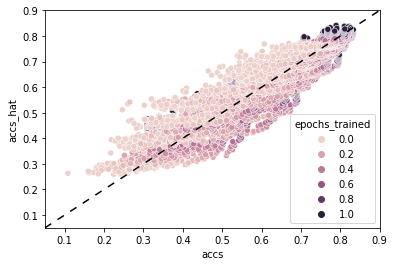

0.8776119152506037

In [104]:
# dataframe for plotting:
y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13])
results["accs_hat"] = y_hat

sns.scatterplot(data = results, x="accs", y = "accs_hat", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results.accs, results.accs_hat)

[-9.99999935  0.03789509  9.63529054  4.09359236  2.04565563  1.70210697
  1.62373228  0.93182625  1.66007155  1.5034354   1.6117244   2.06950381
  1.26054007  1.35890937  3.3211364 ]
25.709134715856976


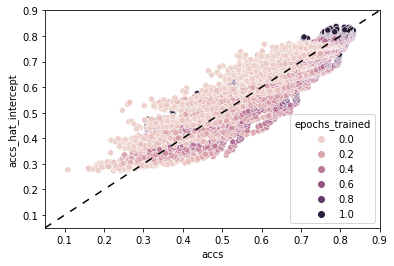

0.8781675457033827


In [111]:
def func_powerlaw_exponent_epoch(x, a: float, b: float, c: float, d_intercept:float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    #: float, x1:float, x2:float, x3:float, x4:float, x5:float, x6:float, x7:float, x8:float, x9:float
    return a + ((d_intercept + d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c

p0 = np.random.uniform(low=-0, high=2, size = 15)

try:
    params, params_cov = curve_fit(func_powerlaw_exponent_epoch, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
except:
    print("did not converge")

print(params)
y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13], params[14])
#results["accs_hat"] = y_hat
print(((y_hat - y)**2).sum())
results["accs_hat_intercept"] = y_hat
sns.scatterplot(data = results, x="accs", y = "accs_hat_intercept", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()
print(metrics.r2_score(results.accs, results.accs_hat_intercept))

#params, params_cov = curve_fit(func_powerlaw_exponent_epoch_2, xdata, y, maxfev=200000, p0=p0_2, bounds=(0, 2))


In [ ]:
#p0 = [0.1, 0.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, 0.1]
#p0_2 = [0.1, 0.1, 0.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1]

p0 = np.random.uniform(low=-0, high=2, size = 15)

try:
    params, params_cov = curve_fit(func_powerlaw_exponent_epoch, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    print(params)
    y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[8], params[9], params[10], params[11], params[12])
    #results["accs_hat"] = y_hat
    print(((y_hat - y)**2).sum())
except:
    print("did not converge")
#params, params_cov = curve_fit(func_powerlaw_exponent_epoch_2, xdata, y, maxfev=200000, p0=p0_2, bounds=(0, 2))



### Try out glm formula interface.

* This would have the advantage that it is easy to try out different functions.
* But the disadvantage is that it stays inside the boundaries of a glm.

In [ ]:
#formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained"
#formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + plane*epochs_trained + car*epochs_trained + bird * epochs_trained + car*epochs_trained + deer*epochs_trained + dog*epochs_trained + frog*epochs_trained + horse * epochs_trained + ship*epochs_trained + truck * epochs_trained"
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + np.power(epochs_trained, 2)"
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + np.power(epochs_trained, 2) + I(plane + car + bird + cat + deer + dog + frog + horse + ship + truck) : epochs_trained"
formula


In [ ]:
tmp = smf.glm(formula=formula, data=results, family=sm.families.Binomial()).fit()
print(tmp.summary())
tmp.fittedvalues

In [ ]:
results = pd.concat([pd.DataFrame({"accs_hat_glm_form": tmp.fittedvalues}), results], axis=1)
results.head(2)

In [ ]:
sns.scatterplot(data = results, x="accs", y = "accs_hat_glm_form", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results.accs, results.accs_hat_glm_form)

In [ ]:
results.head(2)

In [ ]:
features_wo_epoch = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
features = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck", "epochs_trained"]


In [ ]:
#data_exog = sm.add_constant(results.iloc[:,1:(-1)], prepend=False)
data_exog = sm.add_constant(results[features], prepend=False)

data_exog.head(2)
data_endog = results.accs
glm_binom = sm.GLM(data_endog, data_exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

In [ ]:
#glm = pd.concat([])
results = pd.concat([pd.DataFrame({"accs_hat_glm": res.fittedvalues}), results], axis=1)
results.head(2)

In [ ]:

sns.scatterplot(data = results, x="accs", y = "accs_hat_glm", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results.accs, results.accs_hat_glm)

### Doing some other attempts to find good fits

* Using transformations.

In [ ]:
# dataframe for plotting:
y_hat = func_powerlaw_exponent_epoch(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[8], params[9], params[10], params[11], params[12])
results["accs_hat"] = y_hat

sns.scatterplot(data = results, x="accs", y = "accs_hat", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results.accs, results.accs_hat)

In [ ]:
lr = linear_model.LogisticRegression()
print(np.transpose(xdata).shape)
print(y.shape)
pd.Series(y)
#lr.fit(X=np.transpose(xdata), y=pd.Series(y))
# hm, transform y's to -inf, inf and use standard linear regression.
y_tan = np.tan(np.pi*(y - 1/2))
y_phi = stats.norm().ppf(y)

lr_tan = linear_model.LinearRegression()
lr_tan.fit(X=np.transpose(xdata), y=y_tan)
y_tan_hat = lr_tan.predict(np.transpose(xdata))

lr_phi = linear_model.LinearRegression()
lr_phi.fit(X=np.transpose(xdata), y=y_phi)
y_phi_hat = lr_phi.predict(np.transpose(xdata))
y_hat_phi = stats.norm.pdf(y_phi_hat)
plt.scatter(y_phi, y_phi_hat)
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()
plt.scatter(y, y_hat_phi)
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

plt.scatter(y_tan, y_tan_hat)
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

The fit is here still to be improved. Especially the effect of the epochs is not captured well by the prediction function.

### Restrict all data to the same epoch:

In [ ]:
# do the same without epoch:
mask = results.epochs_trained == 1
results_final_epoch = results[mask][["accs"] + features_wo_epoch].reset_index(drop=True)
#results_final_epoch.head(2)
xdata = np.transpose(results_final_epoch.to_numpy()[:, 1:])
y = results_final_epoch.to_numpy()[:, 0]
#xdata.shape


In [ ]:
p0 = [0.1, 0.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1]
params, params_cov = curve_fit(func_powerlaw_exponent,
                                xdata,
                                y,
                                maxfev=200000,
                                p0=p0,
                                bounds=(0, 4))

In [ ]:
params

In [ ]:
y_hat = func_powerlaw_exponent(xdata, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[8], params[9], params[10], params[11])
results_final_epoch["accs_hat"] = y_hat

sns.scatterplot(data=results_final_epoch, x="accs", y = "accs_hat")
plt.xlim((0.2, 0.9))
plt.ylim((0.2, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results_final_epoch.accs, results_final_epoch.accs_hat)

* Fitting to the data coming from the same no. of epochs yields a much better prediction.

# Notebook junkyard:

### experiment with maximin optimization on constrained simplex mixture designs.

In [ ]:
from dexpy.samplers import uniform_simplex_sample
from scipy import spatial
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def create_constrained_mixture_design(d, n, n_sum, c_max, n_optim):
    """a version using point wise generation and point wise replacement."""
    #d = 4
    #n = 20
    #n_optim = 1000
    #n_sum = 10000
    #c_max = 5000
    n_sample = 0
    # create a first doe
    while n_sample < n:
        candidate = uniform_simplex_sample(1, d) 
        candidate_scaled = candidate * n_sum
        if (candidate_scaled > c_max).sum() == 0:
            if n_sample == 0:
                doe_best = candidate
                doe_best_scaled = candidate_scaled
                n_sample += 1
            else:
                doe_best = np.append(doe_best, candidate, axis = 0)
                doe_best_scaled = np.append(doe_best_scaled, candidate_scaled, axis = 0)
                n_sample += 1
    Mm = 0
    # improve the doe iteratively:
    for i in range(n_optim):
        candidate = doe_best
        candidate_scaled = doe_best_scaled
        dm = spatial.distance_matrix(candidate, candidate)
        np.fill_diagonal(dm, 20)
        dm_argmin = dm.min(axis=1).argmin()
        n_sample = 0
        while n_sample == 0:
            candidate_row = uniform_simplex_sample(1, d)
            candidate_row_scaled = candidate_row * n_sum
            if (candidate_row_scaled > c_max).sum() == 0:
                n_sample = 1
        candidate[dm_argmin,:] = candidate_row
        candidate_scaled[dm_argmin,:] = candidate_row_scaled
        if dm.min() > Mm:
            print(dm.min(), i)
            doe_best = candidate
            doe_best_scaled = candidate_scaled
            dm_best = dm
            Mm = dm.min()
    return np.round(doe_best_scaled)


In [ ]:
def uniform_simplex_sample(N, q, clip=None):
    """Returns an array of points sampled uniformly from a simplex

    :param N: the number of random sample to be generated
    :param q: the dimension of the simplex
    """
    sample = np.random.exponential(1.0, (N, q))
    if clip is not None:
        sample = np.clip(sample, 0, clip)
    row_sums = sample.sum(axis=1)
    sample = sample / row_sums[:, np.newaxis]
    return sample



In [ ]:
def uniform_simplex_sample(N, q, clip=None):
    """Returns an array of points sampled uniformly from a simplex

    :param N: the number of random sample to be generated
    :param q: the dimension of the simplex
    """
    sample = np.random.exponential(1.0, (N, q))
    if clip is not None:
        sample = np.clip(sample, 0, clip)
    row_sums = sample.sum(axis=1)
    sample = sample / row_sums[:, np.newaxis]
    return sample

def create_constrained_mixture_design(d, n, n_sum, c_max, n_optim, n_batch_size):
    """a version doing batch wise candidate generation and pointwise replacement."""
    #d = 4
    #n = 20
    #n_optim = 1000
    #n_sum = 10000
    #c_max = 5000
    #n_batch_size = 10000
    n_sample = 0
    # create a first doe
    clip = None
    loop_no = 0
    while n_sample < n:
        candidate = uniform_simplex_sample(n_batch_size, d, clip=clip) 
        candidate_scaled = candidate * n_sum
        # kick out non-acceptable rows:
        matches = np.where((candidate_scaled <= c_max).sum(axis=1) == d)[0]
        if matches.shape[0] > 0:
            candidate = candidate[matches,:]
            candidate_scaled = candidate_scaled[matches,:]
            if n_sample == 0:
                if candidate.shape[0] <= n:
                    doe_best = candidate
                    doe_best_scaled = candidate_scaled
                else:
                    doe_best = candidate[:n,:]
                    doe_best_scaled = candidate_scaled[:n,:]
                n_sample = doe_best.shape[0]
            else:
                doe_best = np.append(doe_best, candidate, axis = 0)
                doe_best_scaled = np.append(doe_best_scaled, candidate_scaled, axis=0)
                n_sample = doe_best.shape[0]
        else:
            if loop_no == 0:
                clip = 10
                loop_no += 1
            clip = clip * 0.9
            print(f"clip = {clip}")

        # reduce if oversampled:
    if n_sample > n:
        doe_best = doe_best[:n, :]
        doe_best_scaled = doe_best_scaled[:n, :]
    #    (candidate_scaled <= c_max)
    #    if (candidate_scaled > c_max).sum() == 0:
    #        if n_sample == 0:
    #            doe_best = candidate
    #            doe_best_scaled = candidate_scaled
    #            n_sample += 1
    #        else:
    #            doe_best = np.append(doe_best, candidate, axis = 0)
    #            doe_best_scaled = np.append(doe_best_scaled, candidate_scaled, axis = 0)
    #            n_sample += 1
    Mm = 0
    # improve the doe iteratively:
    for i in range(n_optim):
        candidate = doe_best
        candidate_scaled = doe_best_scaled
        dm = spatial.distance_matrix(candidate, candidate)
        np.fill_diagonal(dm, 20)
        dm_argmin = dm.min(axis=1).argmin()
        n_sample = 0
        while n_sample == 0:
            candidate_rows = uniform_simplex_sample(n_batch_size, d, clip=clip) 
            candidate_rows_scaled = candidate_rows * n_sum
            # kick out non-acceptable rows:
            matches = np.where((candidate_rows_scaled <= c_max).sum(axis=1) == d)[0]
            if matches.shape[0] > 0:
                n_sample = 1
                # in this point wise exchange algo we only need one point:
                candidate_row = candidate_rows[matches[0]]
                candidate_row_scaled = candidate_rows_scaled[matches[0]]
            else:
                if loop_no == 0:
                    clip = 10
                    loop_no += 1
                clip = clip * 0.95
                print(f"clip = {clip}")
        candidate[dm_argmin,:] = candidate_row
        candidate_scaled[dm_argmin,:] = candidate_row_scaled
        if dm.min() > Mm:
            print(dm.min(), i)
            doe_best = candidate
            doe_best_scaled = candidate_scaled
            dm_best = dm
            Mm = dm.min()
    return np.round(doe_best_scaled)


In [ ]:
#doe = create_constrained_mixture_design(d=10, n=20, n_sum=48000, c_max=5000, n_optim=1000, n_batch_size=100000)
